In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.iolib import SimpleTable
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt, het_white, het_arch, acorr_ljungbox
from statistics import *
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit
from scipy.stats.stats import kurtosis, skew
from scipy.stats import boxcox
from IPython.core.display import display
from patsy import dmatrices
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from arch.univariate import ARX, ARCH, GARCH
import warnings
from datetime import datetime, timedelta
import seaborn as sns
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 15

In [2]:
df = pd.read_csv('./data/RTSI-dailyhistory-ru.csv', parse_dates=['Date'], index_col='Date', dayfirst=True)
series = df[('2009-01' < df.index) & (df.index < '2020-02')].Close
series = series.resample('14d').last()

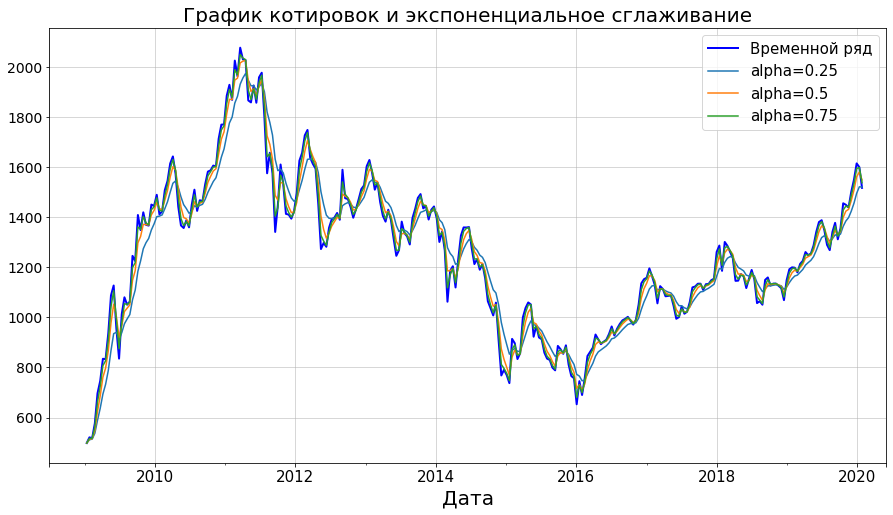

In [3]:
ax = series.plot(legend=True, color='blue', label='Временной ряд', linewidth=2)
for alpha in [.25, .5, .75]:
    series.ewm(alpha=alpha).mean().plot(ax=ax, label=f'alpha={alpha}', legend=True)
ax.set_title('График котировок и экспоненциальное сглаживание')
ax.set_xlabel('Дата');
ax.set_xlim('2008-07', '2020-06')
del ax

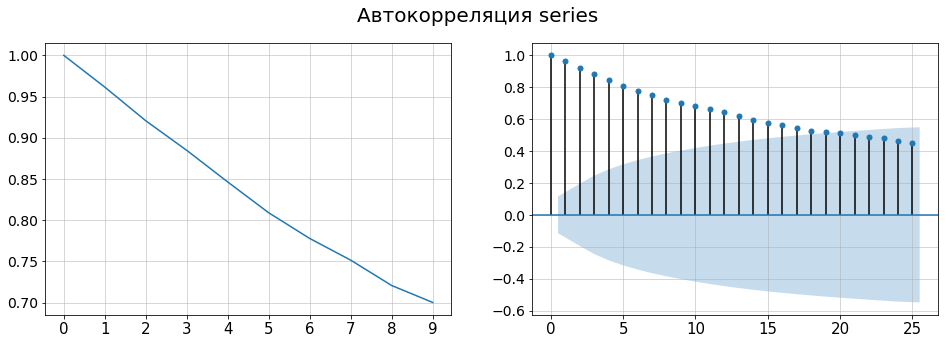

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
fig.suptitle('Автокорреляция series')

ax1.set_xticks(np.linspace(0, 10, 11))
ax1.plot(acf(series, fft=False)[:10])

plot_acf(series, ax=ax2, title='');

plt.show();
del fig, ax1, ax2

### Тест Фуллера на стационарность ряда

In [5]:
fuller_test = adfuller(series)
if fuller_test[0] > fuller_test[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
del fuller_test

Ряд нестационарен


# Составление тренда 

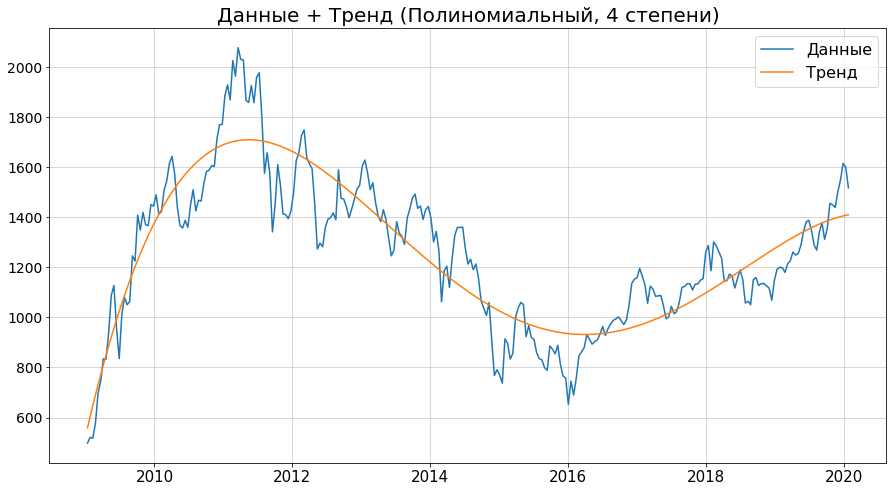

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     293.7
Date:                Thu, 26 Mar 2020   Prob (F-statistic):           1.37e-99
Time:                        14:31:42   Log-Likelihood:                -1823.8
No. Observations:                 289   AIC:                             3658.
Df Residuals:                     284   BIC:                             3676.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        559.3254     38.711     14.449      0.000     483.129     635.522
x1            45.1658      1.869     24.162      0.000      41.486      48.845
x2            -0.5664      0.026    -21.407      0.000      -0.619      -0.514
x3             0.0024      0.000     17.499      0.000       0.002       0.003
x4         -3.332e-06   2.38e-07    -14.004      0.000    -3.8e-06   -2.86e-06
==============================================================================
Omnibus:                        0.641   Durbin-Watson:                   0.262
Prob(Omnibus):                  0.726   Jarque-Bera (JB):                0.745
Skew:                          -0.032   Prob(JB):                        0.689
Kurtosis:                       2.760   Cond. No.                     1.13e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
pf = PolynomialFeatures(degree=4)
xp = pf.fit_transform(np.arange(series.size)[:, np.newaxis])
fitted_model = sm.OLS(series, xp).fit()

plt.title('Данные + Тренд (Полиномиальный, 4 степени)')
plt.plot(series, label='Данные')

# Значения линии тренда
# Вместо .fittedvalues можно .predict(xp)
series_trend = fitted_model.fittedvalues
series_remains = fitted_model.resid
series_remains_exog = fitted_model.model.exog

plt.plot(series_trend, label='Тренд');
plt.legend(fontsize=16)
plt.show()
display(fitted_model.summary())
del pf, xp, fitted_model

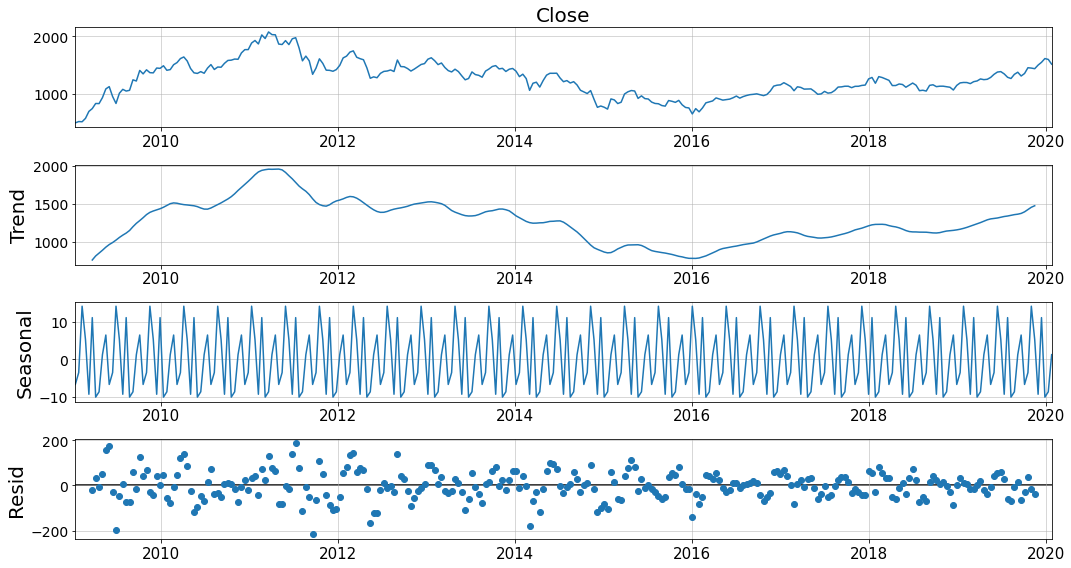

In [7]:
sm.tsa.seasonal_decompose(series.interpolate(), period=10).plot();

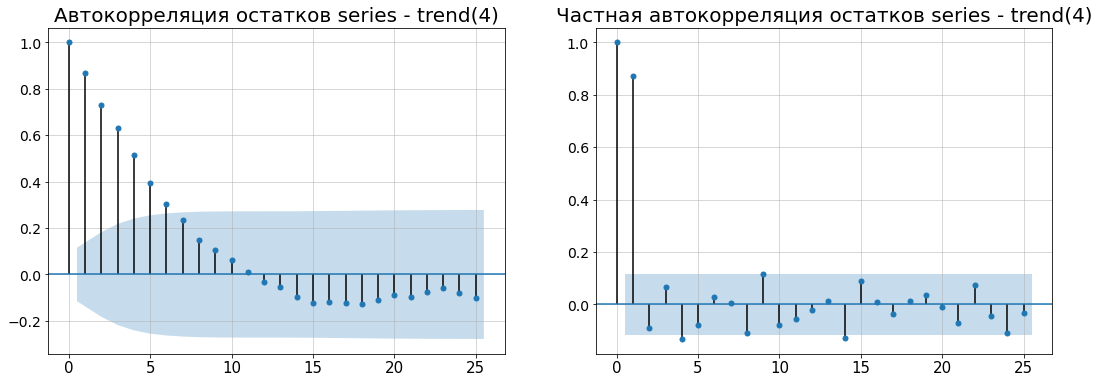

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
plot_acf(series_remains, title='Автокорреляция остатков series - trend(4)', ax=ax1);
plot_pacf(series_remains, title='Частная автокорреляция остатков series - trend(4)', ax=ax2);

In [97]:
# Лучшие pdq - 4, 0, 4
model = ARIMA(series_remains, order=(4, 0, 4))
arima_by_series_remains = model.fit()
display(arima_by_series_remains.summary())

del model

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  289
Model:                     ARMA(4, 4)   Log Likelihood               -1606.610
Method:                       css-mle   S.D. of innovations             62.307
Date:                Thu, 26 Mar 2020   AIC                           3233.220
Time:                        16:24:12   BIC                           3269.885
Sample:                    01-11-2009   HQIC                          3247.912
                         - 01-26-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1253      3.263      0.038      0.969      -6.270       6.521
ar.L1.y        1.1503      0.057     20.182      0.000       1.039       1.262
ar.L2.y       -0.4925      0.078     -6.326      0.000      -0.645      -0.340
ar.L3.y        1.1378      0.061     18.602      0.000       1.018       1.258
ar.L4.y       -0.8284      0.042    -19.928      0.000      -0.910      -0.747
ma.L1.y       -0.2348      0.083     -2.819      0.005      -0.398      -0.072
ma.L2.y        0.1405      0.050      2.806      0.005       0.042       0.239
ma.L3.y       -0.8978      0.060    -14.984      0.000      -1.015      -0.780
ma.L4.y       -0.0078      0.071     -0.110      0.913      -0.146       0.131
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3771           -0.9566j            1.0283           -0.3098
AR.2           -0.3771           +0.9566j            1.0283            0.3098
AR.3            1.0638           -0.0999j            1.0685           -0.0149
AR.4            1.0638           +0.0999j            1.0685            0.0149
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.4207           -0.9671j            1.0546           -0.3153
MA.3           -0.4207           +0.9671j            1.0546            0.3153
MA.4         -115.8787           -0.0000j          115.8787           -0.5000
-----------------------------------------------------------------------------
"""

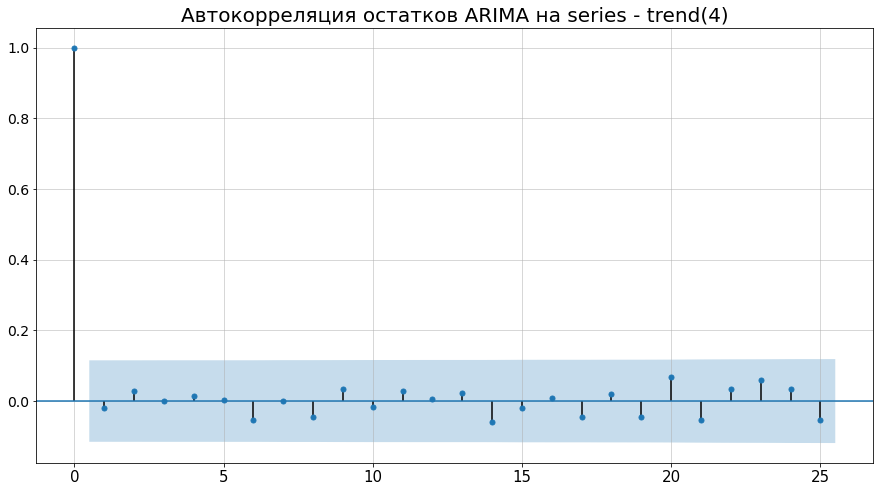

In [10]:
plot_acf(arima_by_series_remains.resid, title='Автокорреляция остатков ARIMA на series - trend(4)');

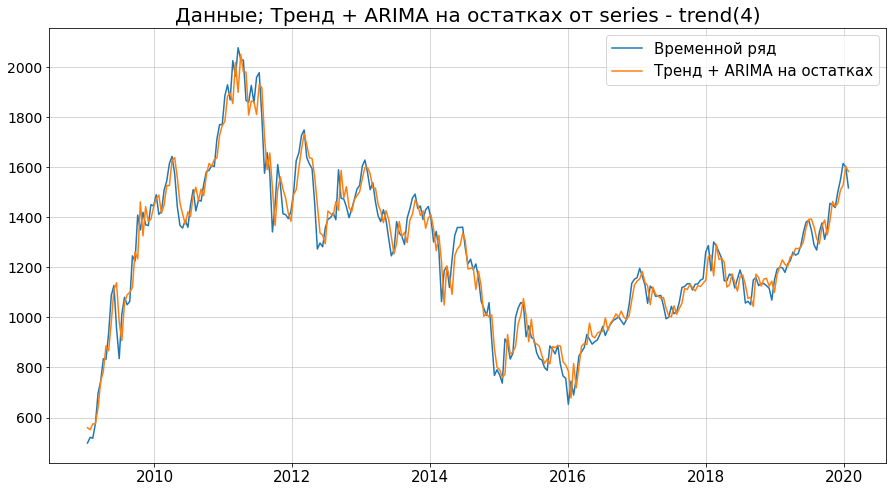

In [11]:
plt.plot(series, label='Временной ряд');
plt.plot(series_trend + arima_by_series_remains.fittedvalues, label='Тренд + ARIMA на остатках');
plt.title('Данные; Тренд + ARIMA на остатках от series - trend(4)')
plt.legend()
plt.show()

# Проверка предпосылок регрессионного анализа (остатков от тренда)
#### - Нулевая средняя величина
#### - Остатки подчиняются нормальному распределению
#### - Случайный характер остатков
#### - Гомоскедастичность
#### - Отсутствие автокорреляции
#### (Некоторые тесты выводятся выше при составлении тренда (Дарбин-Уотсон)

## 1)Нулевая средняя величина

In [12]:
print('Средняя величина остатков:', series_remains.mean())

Средняя величина остатков: -1.3948823423964228e-05


## 2)Остатки подчиняются нормальному распределению 

### На уровне значимости 0.05, нулевая гипотеза о нормальности распределения принимается

In [13]:
display(SimpleTable(
    np.array([sm.stats.stattools.jarque_bera(series_remains)]),
     ['JB', 'p-value', 'skew', 'kurtosis']
))
# Гипотеза Н0 - о нормальном распределении остатков
# Чем ближе распределение ошибок к нормальному, тем меньше статистика Харке—Бера отличается от нуля.
#При достаточно большом значении статистики p-value будет мало,
#и тогда будет основание отвергнуть нулевую гипотезу (статистика попала в «хвост» распределения). 

JB,p-value,skew,kurtosis
0.7452969150737438,0.6889073704745163,-0.03184481120151029,2.7595071697200737


### Критерии ассиметрии и эксцесса, и РС

In [14]:
kurt = kurtosis(series_remains)
n = series_remains.size
kurt_critical = 5*(24*n*(n-2)*(n-3)/(n+1)**2/(n+3)/(n+4))**.5
sk = skew(series_remains)
sk_critical = 3*(6*(n-1)/(n+1)/(n+3))**.5

if kurt < kurt_critical:
    print(f'Эксцесс {kurt:.4f} меньше критического {kurt_critical:.4f}')
else:
    print(f'Эксцесс {kurt:.4f} больше, либо равен критическому {kurt_critical:.4f}')

if sk < sk_critical:
    print(f'Ассиметрия {sk:.4f} меньше критического {sk_critical:.4f}')
else:
    print(f'Ассиметрия {sk:.4f} больше, либо равна критической {sk_critical:.4f}')
    
rem = series_remains
# Полученное значение сравнивается с табличными 
# С вероятностью ошибки-0.05 и длиной выборки-100 РС критерий должен быть в диапазон(4.31; 5.9)
rc = (rem.max() - rem.min()) / ((rem**2).sum()/len(rem)-1)**.5
print(f'РС критерий: {rc:.4f}')

Эксцесс -0.2405 меньше критического 1.4065
Ассиметрия -0.0318 меньше критического 0.4286
РС критерий: 5.4384


## 3)Случайный характер остатков 

In [15]:
fuller_test = adfuller(series_remains)
if fuller_test[0] > fuller_test[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
del fuller_test
#H0 - наличие единичного корня т.е. нестационарность ряда
# Если p-value (второе значение теста) больше критического (0.05), то мы не можем отвергнуть нулевую гипотезу
# + проверяем значение самого теста. Если значение > критического от 5%, то ряд нестационарен.

Ряд стационарен


## 4)Гомоскедастичность

In [78]:
bp_test = het_breuschpagan(series_remains, series_remains_exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels, bp_test)))
# H0 - наличие гомоскедастичности. Если оба p-value меньше 0.05 - гетероскедастичность

{'LM Statistic': 36.29335684049066, 'LM-Test p-value': 2.5182053387658033e-07, 'F-Statistic': 10.196915694251595, 'F-Test p-value': 9.976655524196052e-08}


In [79]:
het_goldfeldquandt(series_remains, series_remains_exog, store=True)
# H0 - о равенстве дисперсий в двух подвыборках (гомоскедастичность)
# Смотрим на второе число (p-value) - p-value гипотезы что дисперсии отличаются. Если большое, то гетероскедастичность

(0.2878614944830237,
 0.999999999999451,
 'increasing',
 <statsmodels.stats.diagnostic.ResultsStore at 0x7f5c91c8a510>)

### Тест Уайта

### F-критическое ищется по таблице F(0.01; 13, 120) = 3.255

### 5.94 > F критическое => уравнение значимое => гетероскедастичность

### Если последнее число(значимость F) < 0.05 => гетероскедастичность

In [86]:
#1 вариант - использует дисперсии
white_test = het_white(series_remains, series_remains_exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels, white_test)))
# Тест аналогичен с бройшем паганом

{'LM Statistic': 33.648632814148776, 'LM-Test p-value': 8.796402747468802e-07, 'F-Statistic': 9.355943365933694, 'F-Test p-value': 4.073719143621304e-07}


### Тест Уайта вручную (другой вариант теста)

### При гетероскедастичности все полученные члены будут значимы и p-value>0.05

In [81]:
tmp = series_remains.to_frame()
tmp['t'] = np.arange(tmp.size)
tmp['t2'] = tmp.t ** 2
tmp['t3'] = tmp.t ** 3
tmp['t4'] = tmp.t2 ** 2
tmp['t22'] = tmp.t2.copy()
tmp['t44'] = tmp.t4.copy()
tmp['t6'] = tmp.t3 ** 2
tmp['t8'] = tmp.t4 ** 2

tmp['a'] = tmp.t3.copy()
tmp['b'] = tmp.t4.copy()
tmp['c'] = tmp.t4 * tmp.t
tmp['d'] = tmp.t4 * tmp.t
tmp['e'] = tmp.t3 ** 2
tmp['f'] = tmp.t3 * tmp.t4
tmp['remains'] = series_remains ** 2

In [82]:
f = smf.ols('remains ~ (t + t2 + t3 + t4 + t22 + t44 + t6 + t8 + a + b + c + d + e + f)', data=tmp).fit()
display(f.summary())
del tmp

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                remains   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.064
Date:                Thu, 26 Mar 2020   Prob (F-statistic):             0.0700
Time:                        15:39:06   Log-Likelihood:                -3314.0
No. Observations:                 289   AIC:                             6640.
Df Residuals:                     283   BIC:                             6662.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    2.48e-06   3.04e-07      8.156      0.000    1.88e-06    3.08e-06
t             -0.0002   2.27e-05     -8.156      0.000      -0.000      -0.000
t2             0.0065      0.001      8.156      0.000       0.005       0.008
t3             0.2053      0.025      8.156      0.000       0.156       0.255
t4            -0.0026      0.000     -7.262      0.000      -0.003      -0.002
t22            0.0065      0.001      8.156      0.000       0.005       0.008
t44           -0.0026      0.000     -7.262      0.000      -0.003      -0.002
t6         -8.132e-08   1.33e-08     -6.098      0.000   -1.08e-07   -5.51e-08
t8         -2.021e-16   4.85e-16     -0.417      0.677   -1.16e-15    7.52e-16
a              0.2053      0.025      8.156      0.000       0.156       0.255
b             -0.0026      0.000     -7.262      0.000      -0.003      -0.002
c           2.695e-05   4.07e-06      6.619      0.000    1.89e-05     3.5e-05
d           2.695e-05   4.07e-06      6.619      0.000    1.89e-05     3.5e-05
e          -8.465e-08   1.37e-08     -6.168      0.000   -1.12e-07   -5.76e-08
f           1.892e-10   3.29e-11      5.755      0.000    1.25e-10    2.54e-10
==============================================================================
Omnibus:                       98.742   Durbin-Watson:                   0.680
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.069
Skew:                           1.558   Prob(JB):                     2.52e-61
Kurtosis:                       6.669   Cond. No.                     9.10e+31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.41e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Тест парка на гомоскедастичность

### Гетероскедастичность если полученные уравнение по F-критерию значимы и значимый КФ при ln фактора

In [23]:
tmp = series.to_frame()
tmp['t'] = np.log(np.arange(1, series.size+1))
tmp['t2'] = np.log(np.arange(1, series.size+1)**2)
tmp['t3'] = np.log(np.arange(1, series.size+1)**3)
tmp['t4'] = np.log(np.arange(1, series.size+1)**4)
tmp['Close2'] = np.log(series_remains ** 2)
tmp

,Close,t,t2,t3,t4,Close2
Date,,,,,,
2009-01-11,498.20,0.000000,0.000000,0.000000,0.000000,8.225855
2009-01-25,520.91,0.693147,1.386294,2.079442,2.772589,8.838095
2009-02-08,517.22,1.098612,2.197225,3.295837,4.394449,9.737998
2009-02-22,576.39,1.386294,2.772589,4.158883,5.545177,9.461840
2009-03-08,696.93,1.609438,3.218876,4.828314,6.437752,7.061489
...,...,...,...,...,...,...
2019-12-01,1501.42,5.652489,11.304978,16.957468,22.609957,9.250973
2019-12-15,1549.40,5.655992,11.311984,16.967975,22.623967,9.981890
2019-12-29,1614.69,5.659482,11.318964,16.978447,22.637929,10.690928


In [24]:
smf.ols('Close2 ~ t', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.323
Date:                Thu, 26 Mar 2020   Prob (F-statistic):              0.129
Time:                        14:31:48   Log-Likelihood:                -690.10
No. Observations:                 289   AIC:                             1384.
Df Residuals:                     287   BIC:                             1392.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5807      0.772     12.415      0.000       8.062      11.100
t             -0.2462      0.162     -1.524      0.129      -0.564       0.072
==============================================================================
Omnibus:                      199.273   Durbin-Watson:                   1.137
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2333.316
Skew:                          -2.689   Prob(JB):                         0.00
Kurtosis:                      15.839   Cond. No.                         24.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
smf.ols('Close2 ~ t2', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.323
Date:                Thu, 26 Mar 2020   Prob (F-statistic):              0.129
Time:                        14:31:48   Log-Likelihood:                -690.10
No. Observations:                 289   AIC:                             1384.
Df Residuals:                     287   BIC:                             1392.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5807      0.772     12.415      0.000       8.062      11.100
t2            -0.1231      0.081     -1.524      0.129      -0.282       0.036
==============================================================================
Omnibus:                      199.273   Durbin-Watson:                   1.137
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2333.316
Skew:                          -2.689   Prob(JB):                         0.00
Kurtosis:                      15.839   Cond. No.                         47.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
smf.ols('Close2 ~ t3', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.323
Date:                Thu, 26 Mar 2020   Prob (F-statistic):              0.129
Time:                        14:31:48   Log-Likelihood:                -690.10
No. Observations:                 289   AIC:                             1384.
Df Residuals:                     287   BIC:                             1392.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5807      0.772     12.415      0.000       8.062      11.100
t3            -0.0821      0.054     -1.524      0.129      -0.188       0.024
==============================================================================
Omnibus:                      199.273   Durbin-Watson:                   1.137
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2333.316
Skew:                          -2.689   Prob(JB):                         0.00
Kurtosis:                      15.839   Cond. No.                         71.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 5)Проверка автокорр.

### Сравниваем эту T-статистику КФ автокорр. с T-табличным 
### (если |Tрасч|>Tтабл, то отклоняем H0 о незначимости коэф)

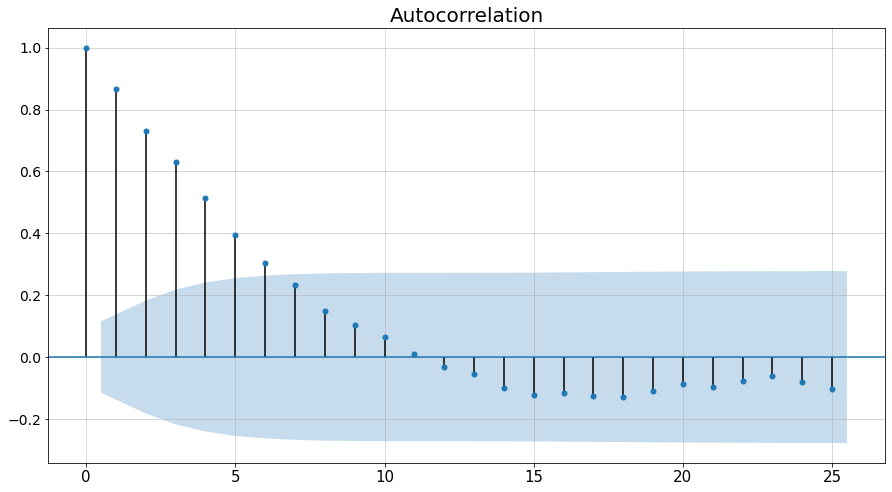

In [27]:
plot_acf(series_remains);

In [94]:
_kf = acf(series_remains, fft=False)[1]
t = (((_kf**2) * (series.size-2)) / (1-_kf**2))**.5

29.564088741245374

In [92]:
#Смотрим на зону, в которую попадает это число. (Если меньше примерно 1.5, то положительная автокорреляция)
durbin_watson(series_remains)

0.26173294501683103

# Проверка остатков после (trend + Arima) 

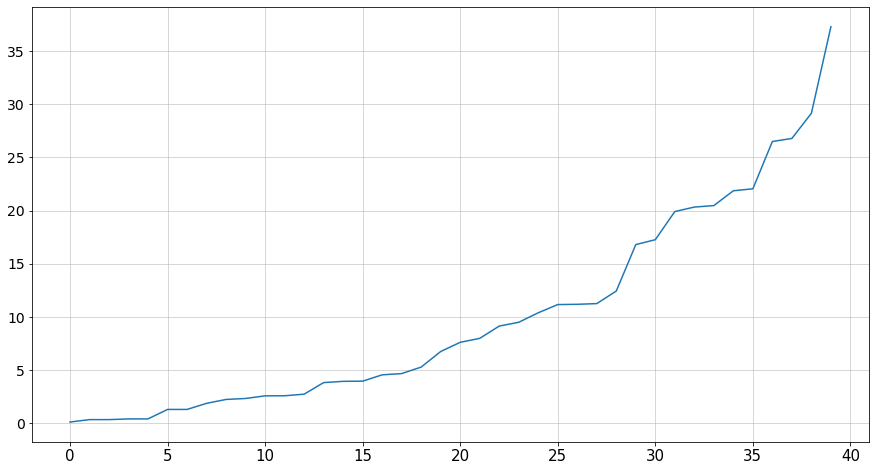

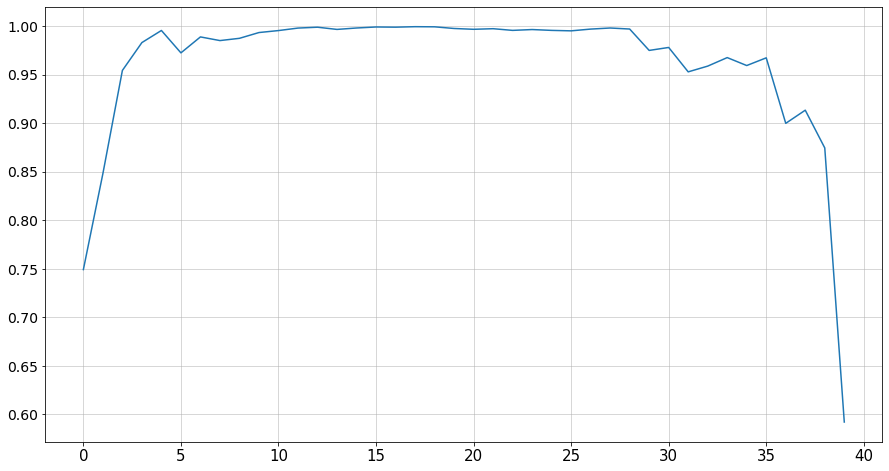

In [29]:
q_test = acf(arima_by_series_remains.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();
del q_test, q_df

In [102]:
acorr_ljungbox(arima_by_series_remains.resid, return_df=True)
# H0 - данные являются "белым шумом"
# Также можно сверить Q статистику с таблицей распределения ХИ-КВАДРАТ

,lb_stat,lb_pvalue
1,0.003894,0.950240
2,0.005844,0.997082
3,0.111347,0.990442
4,0.167144,0.996696
5,0.401242,0.995295
6,2.109527,0.909355
7,2.134448,0.952025
8,2.971088,0.936159
9,3.616098,0.934818
10,3.897969,0.951832


### Остатки полученные после тренд + ARIMA по критерию бокса-льюинга являются белым шумом (поскольку все p-value до 40 лага >0.05)

# ARIMA на исходные данные 

In [30]:
arima_by_series = ARIMA(series, order=(3, 1, 3)).fit()

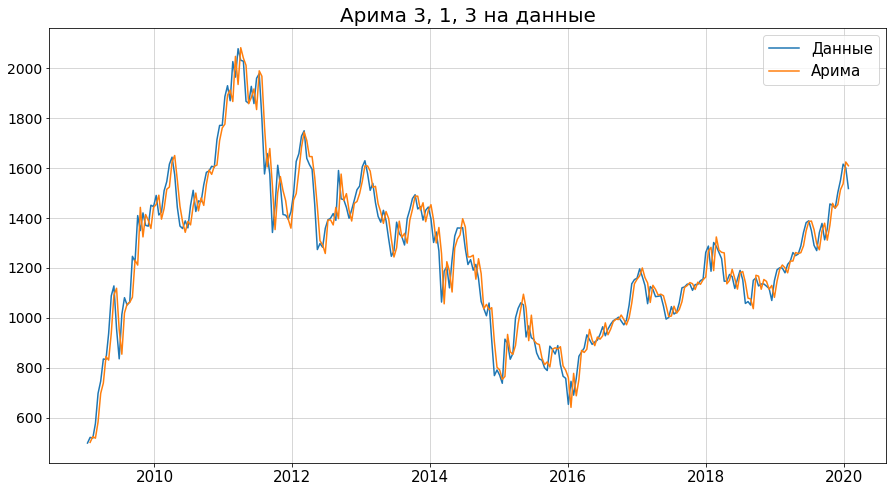

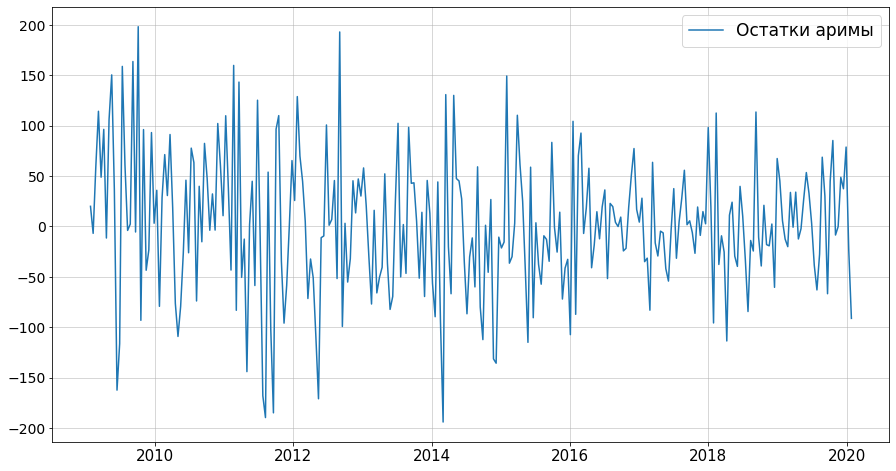

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  288
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1620.680
Method:                       css-mle   S.D. of innovations             67.094
Date:                Thu, 26 Mar 2020   AIC                           3257.360
Time:                        14:31:52   BIC                           3286.664
Sample:                    01-25-2009   HQIC                          3269.103
                         - 01-26-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.7124      2.827      0.960      0.337      -2.828       8.253
ar.L1.D.Close     0.2738      0.046      5.970      0.000       0.184       0.364
ar.L2.D.Close    -0.2331      0.041     -5.655      0.000      -0.314      -0.152
ar.L3.D.Close     0.9373      0.037     25.039      0.000       0.864       1.011
ma.L1.D.Close    -0.2335      0.057     -4.061      0.000      -0.346      -0.121
ma.L2.D.Close     0.1379      0.049      2.835      0.005       0.043       0.233
ma.L3.D.Close    -0.9044      0.057    -15.888      0.000      -1.016      -0.793
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0083           -0.0000j            1.0083           -0.0000
AR.2           -0.3798           -0.9560j            1.0287           -0.3102
AR.3           -0.3798           +0.9560j            1.0287            0.3102
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.4238           -0.9623j            1.0515           -0.3160
MA.3           -0.4238           +0.9623j            1.0515            0.3160
-----------------------------------------------------------------------------
"""

In [31]:
plt.plot(series, label='Данные')
plt.plot(series - arima_by_series.resid, label='Арима')
plt.title(f'Арима {arima_by_series.k_ar}, {arima_by_series.k_diff}, {arima_by_series.k_ma} на данные')
plt.legend(fontsize=15)
plt.show()

plt.plot(arima_by_series.resid, label='Остатки аримы')
plt.legend(fontsize=17)
plt.show();
arima_by_series.summary()

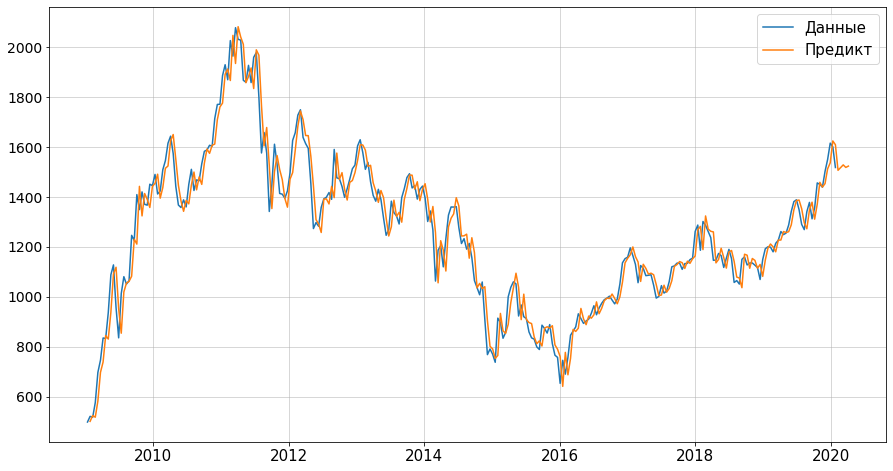

In [32]:
start = series[-1]
predicted = arima_by_series.predict('2020-02', '2020-04')
for i in range(len(predicted)):
    predicted[i] += start
    start = predicted[i]

plt.plot(series, label='Данные')
plt.plot((series - arima_by_series.resid).append(predicted), label='Предикт')
plt.legend()
plt.show();

### Проверим остатки от этой ARIMA на белый шум

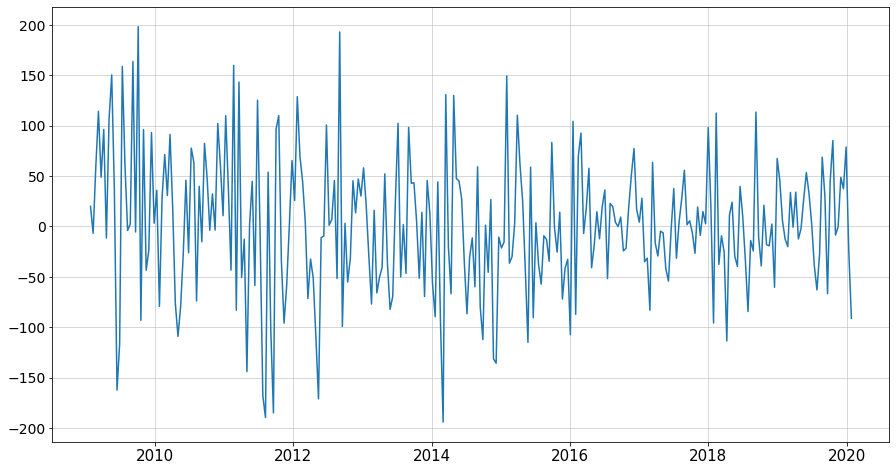

In [103]:
plt.plot(arima_by_series.resid, label='Остатки аримы')

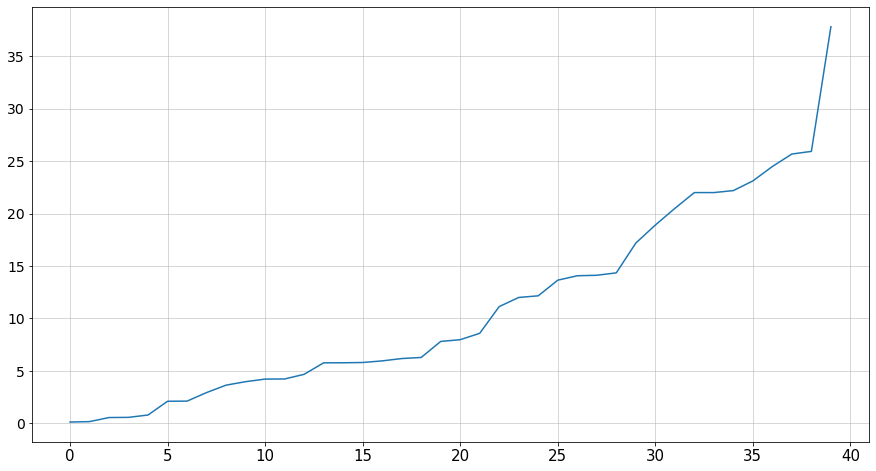

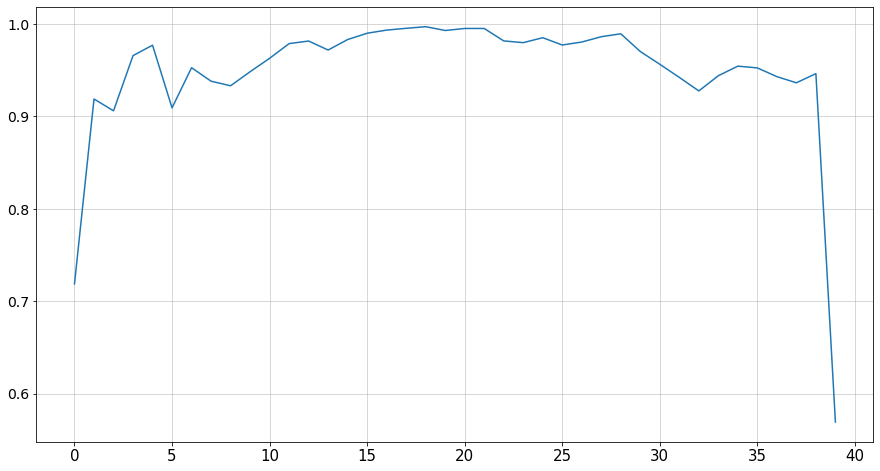

In [105]:
q_test = acf(arima_by_series.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();
del q_test, q_df

In [107]:
acorr_ljungbox(arima_by_series.resid, return_df=True)
# H0 - данные являются "белым шумом"
# Также можно сверить Q статистику с таблицей распределения ХИ-КВАДРАТ

,lb_stat,lb_pvalue
1,0.129754,0.718687
2,0.169184,0.918887
3,0.557498,0.906089
4,0.574767,0.965826
5,0.798375,0.977137
6,2.110250,0.909285
7,2.122577,0.952745
8,2.938419,0.938162
9,3.644952,0.933191
10,3.976411,0.948405


### Пробуем предиктить

In [108]:
series2020 = df[df.index >= '2019-12-31'].Close
predicted2020 = (series - arima_by_series.resid).append(predicted)
predicted2020 = predicted2020[predicted2020.index >= '2019-12']

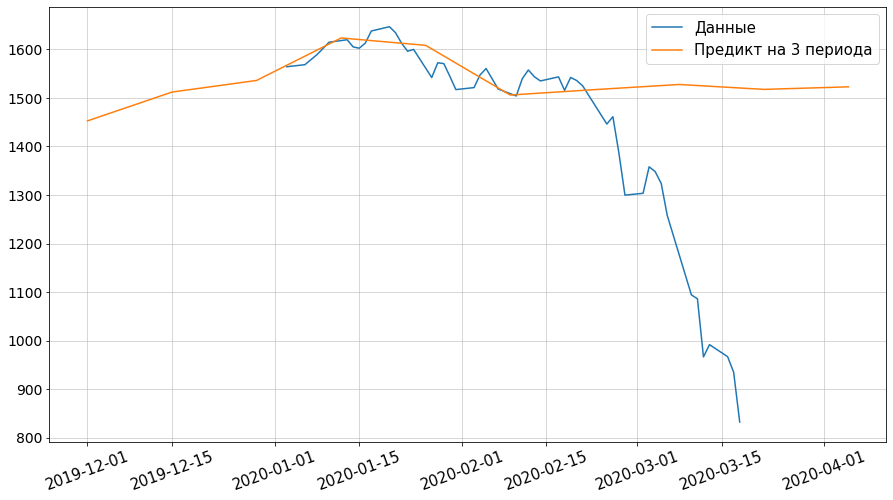

In [109]:
plt.plot(series2020, label='Данные')
plt.plot(predicted2020, label='Предикт на 3 периода')
plt.xticks(rotation=20)
plt.legend();

## Тест CHOW

CHOW : 100%|██████████| 226/226 [00:00<00:00, 984.27 test/s]


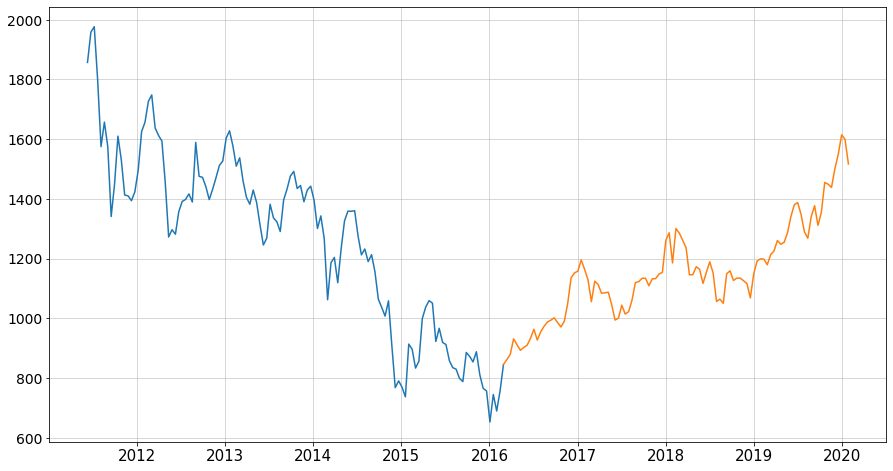

In [127]:
# Оптимальный '2011-10-31' / '2016-03-31'
#chow_test_result, split_point1, partial_series = \
#     Model(series['2011-06': ] ).cut_by_chow_test(arbitrarily=2, with_result=True)
#draw(partial_series)

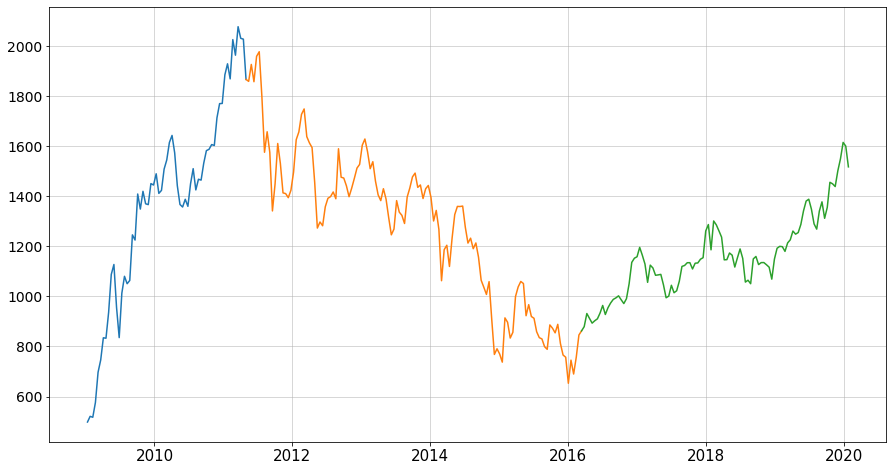

In [130]:
partial_series = PartialModel(series[:'2011-05-01'], series['2011-05':'2016-02'], series['2016-03':])
draw(partial_series)

### 1-ый кусок

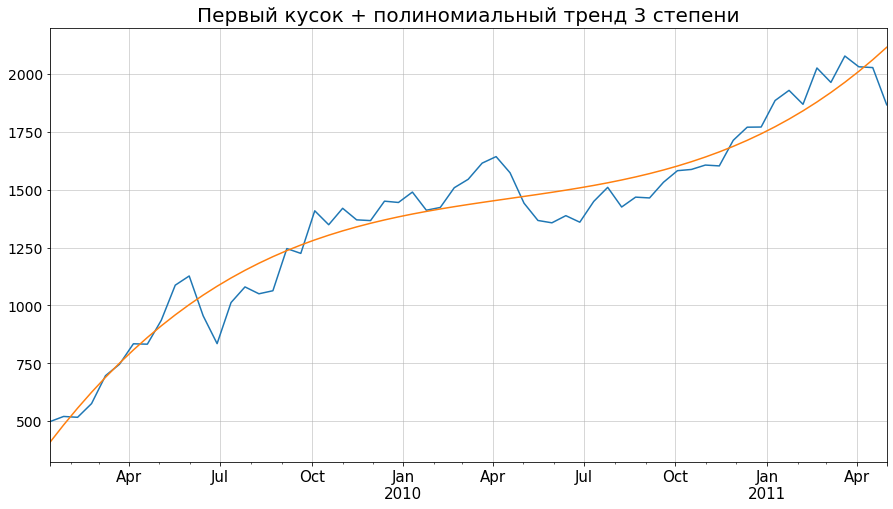

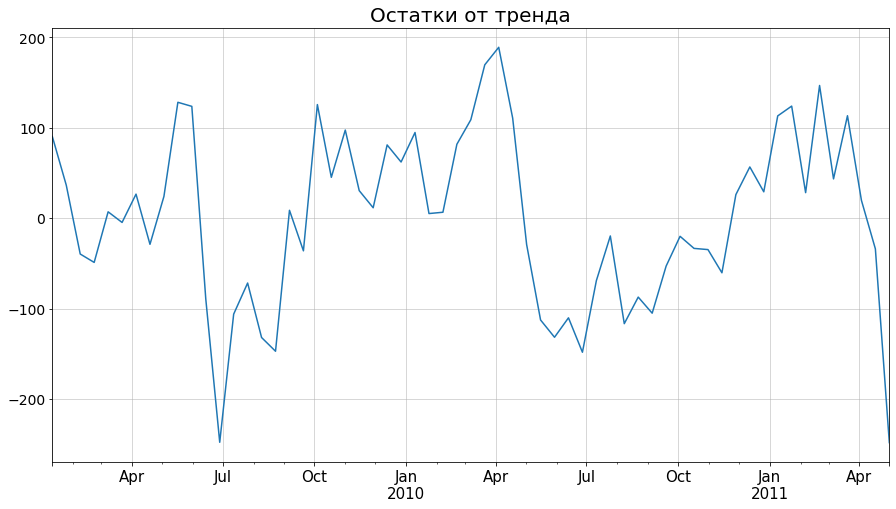

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     308.6
Date:                Thu, 26 Mar 2020   Prob (F-statistic):           3.39e-35
Time:                        17:57:06   Log-Likelihood:                -364.94
No. Observations:                  61   AIC:                             737.9
Df Residuals:                      57   BIC:                             746.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        407.8821     47.858      8.523      0.000     312.048     503.716
x1            78.6446      6.965     11.291      0.000      64.697      92.592
x2            -2.1219      0.271     -7.829      0.000      -2.665      -1.579
x3             0.0214      0.003      7.217      0.000       0.015       0.027
==============================================================================
Omnibus:                        1.392   Durbin-Watson:                   0.691
Prob(Omnibus):                  0.499   Jarque-Bera (JB):                1.275
Skew:                          -0.343   Prob(JB):                        0.529
Kurtosis:                       2.828   Cond. No.                     3.16e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [131]:
partial_series.p1.plot()
partial_series.p1.polynomial_trend(3).plot()
plt.title('Первый кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p1.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p1.polynomial_trend(3).fitted_model.summary())

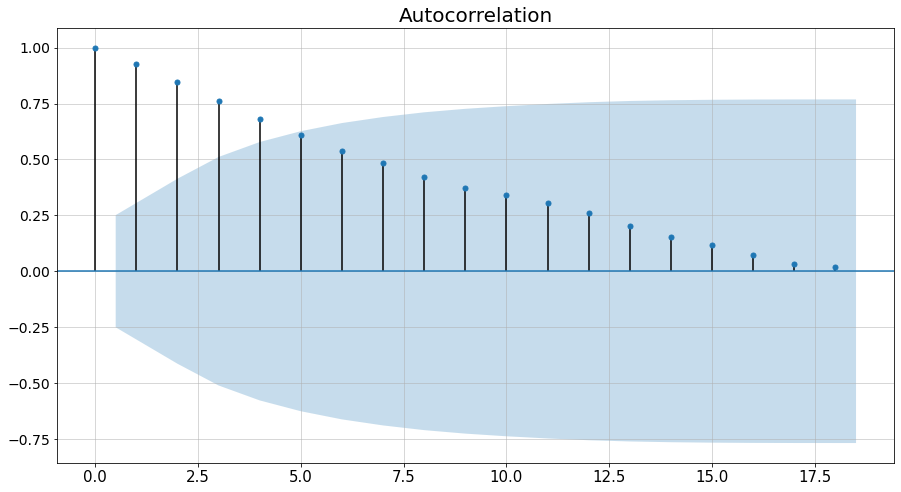

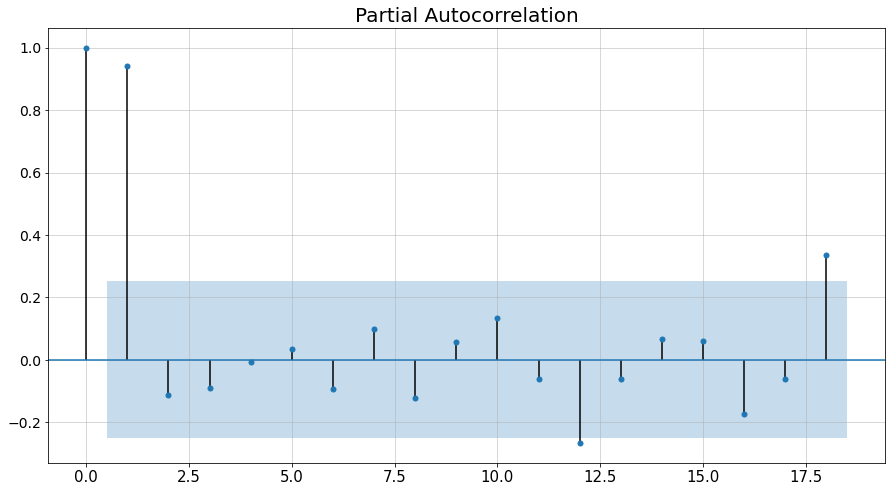

In [132]:
plot_acf(partial_series.p1)
plot_pacf(partial_series.p1);

### 2-ой кусок 

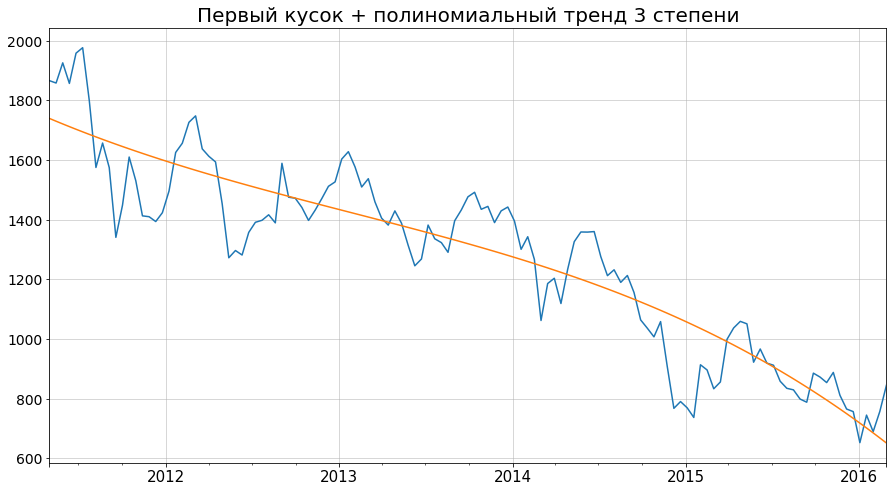

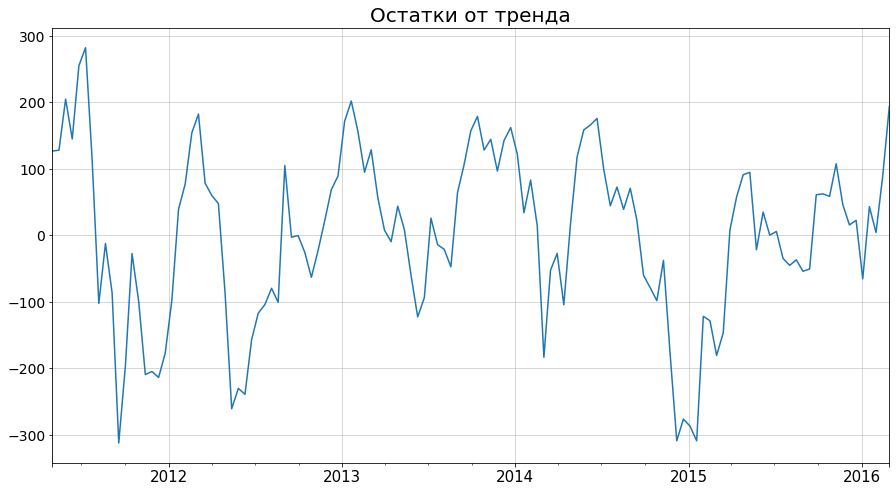

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     207.6
Date:                Thu, 26 Mar 2020   Prob (F-statistic):           5.92e-48
Time:                        17:57:22   Log-Likelihood:                -795.72
No. Observations:                 127   AIC:                             1599.
Df Residuals:                     123   BIC:                             1611.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1739.6667     44.593     39.012      0.000    1651.398    1827.936
x1            -9.3693      3.077     -3.045      0.003     -15.460      -3.278
x2             0.0800      0.057      1.407      0.162      -0.033       0.193
x3            -0.0006      0.000     -1.985      0.049      -0.001   -1.52e-06
==============================================================================
Omnibus:                        4.391   Durbin-Watson:                   0.380
Prob(Omnibus):                  0.111   Jarque-Bera (JB):                4.447
Skew:                          -0.445   Prob(JB):                        0.108
Kurtosis:                       2.784   Cond. No.                     2.97e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.97e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [133]:
partial_series.p2.plot()
partial_series.p2.polynomial_trend(3).plot()
plt.title('Первый кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p2.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p2.polynomial_trend(3).fitted_model.summary())

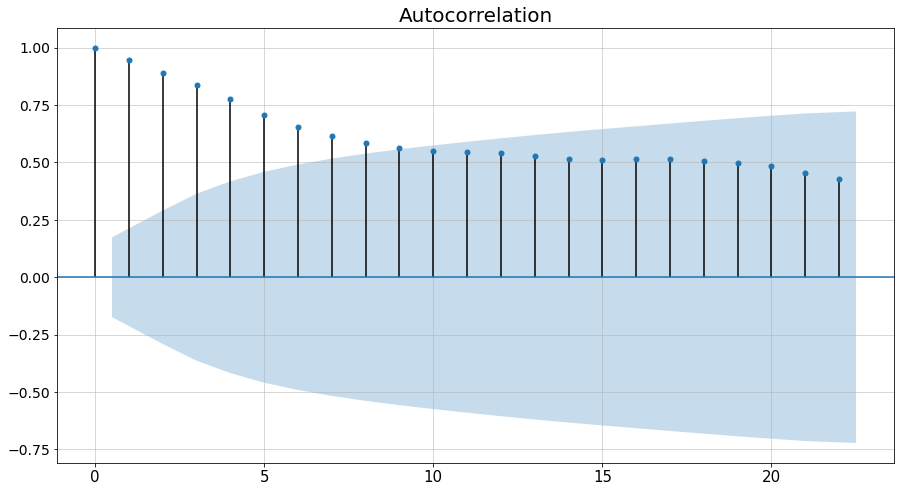

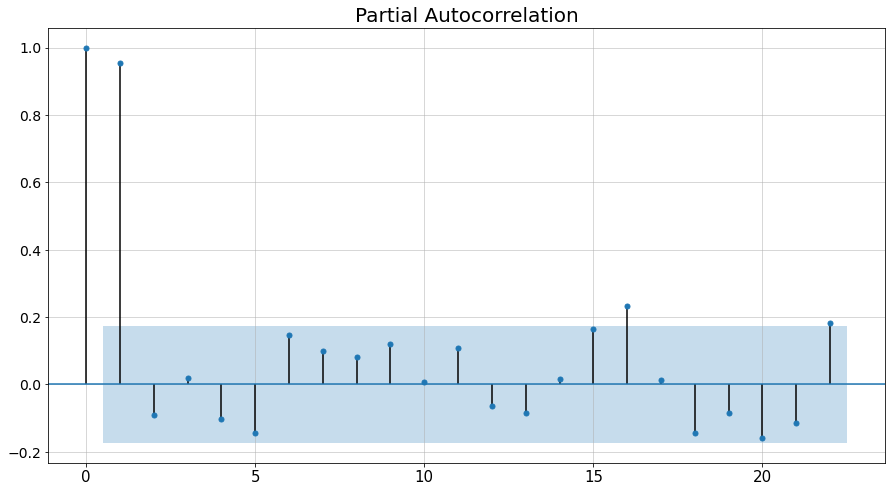

In [134]:
plot_acf(partial_series.p2)
plot_pacf(partial_series.p2);

### 3-ий кусок

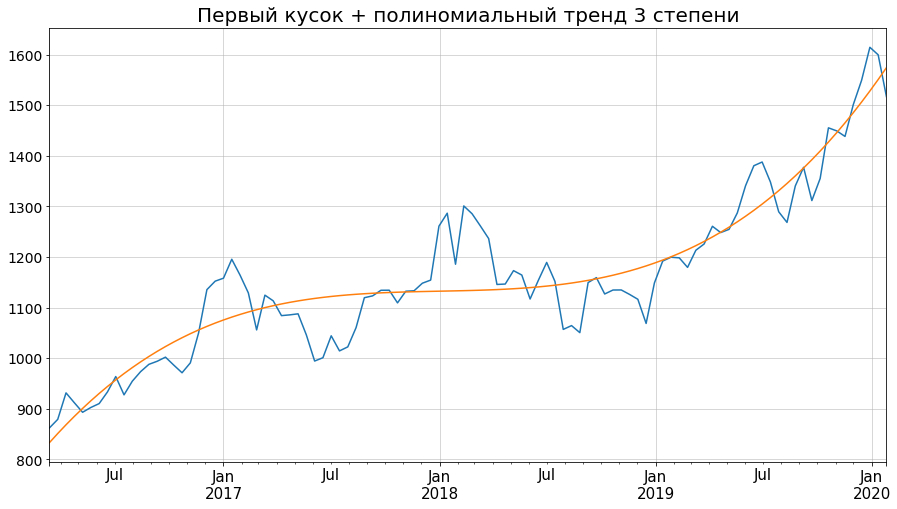

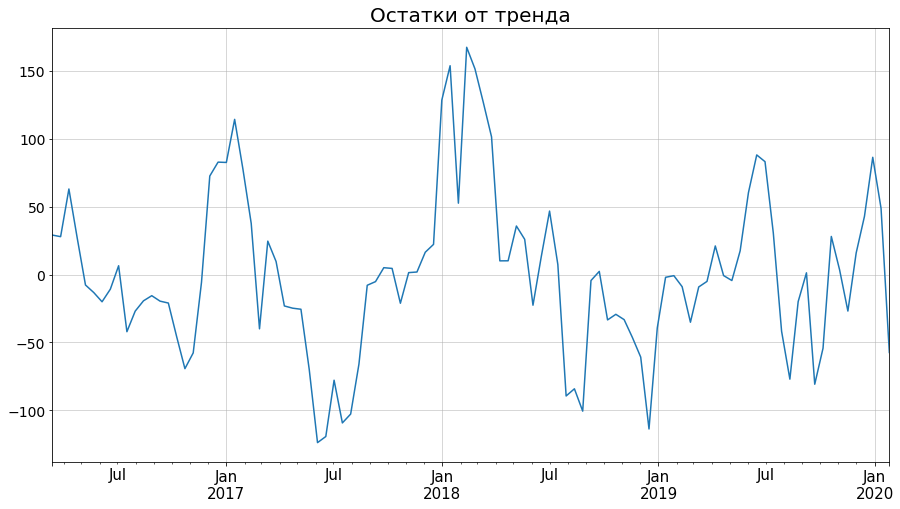

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     203.4
Date:                Thu, 26 Mar 2020   Prob (F-statistic):           6.07e-42
Time:                        17:57:34   Log-Likelihood:                -561.84
No. Observations:                 102   AIC:                             1132.
Df Residuals:                      98   BIC:                             1142.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        833.0810     23.261     35.815      0.000     786.920     879.242
x1            18.4052      2.004      9.183      0.000      14.428      22.383
x2            -0.3836      0.046     -8.295      0.000      -0.475      -0.292
x3             0.0027      0.000      9.017      0.000       0.002       0.003
==============================================================================
Omnibus:                        4.868   Durbin-Watson:                   0.497
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                4.209
Skew:                           0.457   Prob(JB):                        0.122
Kurtosis:                       3.393   Cond. No.                     1.52e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [135]:
partial_series.p3.plot()
partial_series.p3.polynomial_trend(3).plot()
plt.title('Первый кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p3.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p3.polynomial_trend(3).fitted_model.summary())

### Выведем склеенный тренд и применим на все остатки ARIMA

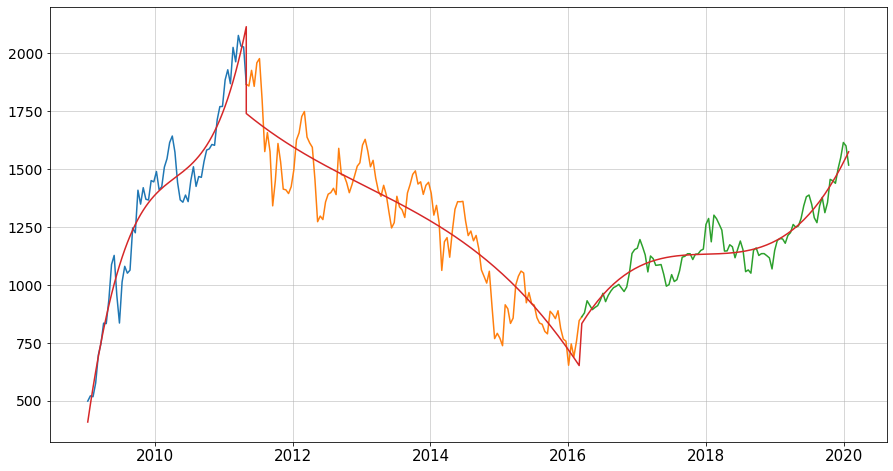

In [136]:
draw(partial_series);
partial_series_trend = (
    partial_series.p1.polynomial_trend(3)
    .append(partial_series.p2.polynomial_trend(3))
    .append(partial_series.p3.polynomial_trend(3))
)
partial_series_trend_remains = (series - partial_series_trend)
draw(partial_series_trend);

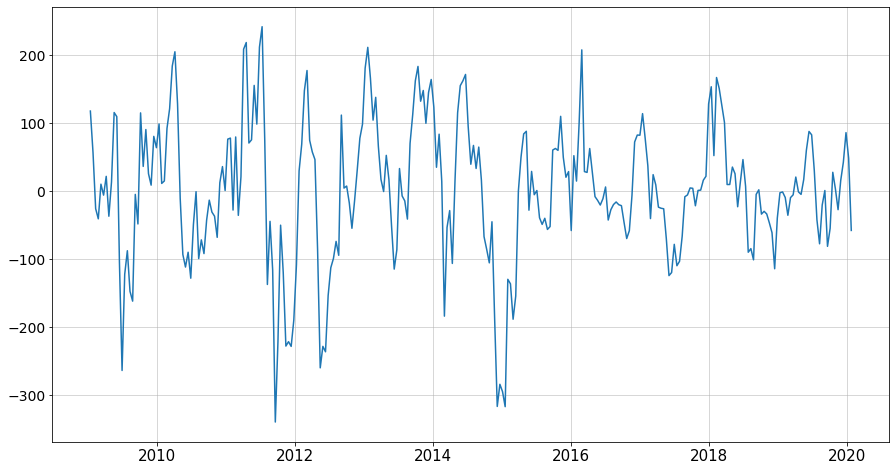

In [43]:
draw(partial_series_trend_remains);

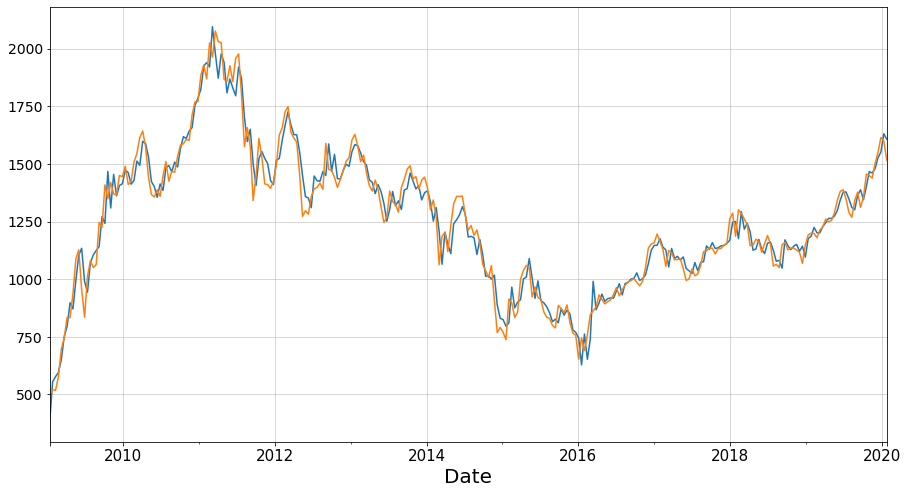

In [44]:
_ = ARIMA(partial_series_trend_remains, order=(5, 0, 4)).fit()
(partial_series_trend + _.fittedvalues).plot()
series.plot();

### Оценивание точности

In [45]:
def mape(other1, other):
    """ Критерий MAPE """
    return np.mean(np.abs((other1 - other) / other1)) * 100

def mae(other1, other):
    """ Критерий MAE """
    return np.mean(np.abs(other1 - other))

In [46]:
print(mape(series, series_trend + arima_by_series_remains.fittedvalues))
mae(series, series_trend + arima_by_series_remains.fittedvalues)

4.02016419857757


48.194254685101065

In [47]:
print(mape(series, series - arima_by_series.resid))
mae(series, series - arima_by_series.resid)

4.2670049671026735


51.489938392702264

In [48]:
print(mape(series, (partial_series_trend + _.fittedvalues)))
mae(series, (partial_series_trend + _.fittedvalues))

3.995910219132625


47.295667921034806

# ARX-GARCH модель

In [49]:
week_series = df[('2009-01' < df.index) & (df.index < '2020')].Close
week_series = week_series.resample('11d').last()

ar_by_week_series = ARX(week_series, lags=1)
ar_by_week_series_fitted = ar_by_week_series.fit()
display(ar_by_week_series_fitted.summary())

argarch_by_week_series = ar_by_week_series
argarch_by_week_series.volatility = GARCH(p=1, q=1)
argarch_by_week_series_fitted = argarch_by_week_series.fit()
argarch_by_week_series_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     AR - Constant Variance Model Results                     
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.956
Mean Model:                        AR   Adj. R-squared:                  0.956
Vol Model:          Constant Variance   Log-Likelihood:               -2019.70
Distribution:                  Normal   AIC:                           4045.40
Method:            Maximum Likelihood   BIC:                           4057.09
                                        No. Observations:                  364
Date:                Thu, Mar 26 2020   Df Residuals:                      361
Time:                        14:32:03   Df Model:                            3
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const         38.5468     14.977      2.574  1.006e-02 [  9.193, 67.901]
Close[1]       0.9714  1.234e-02     78.750      0.000 [  0.947,  0.996]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2      3863.6534    385.085     10.033  1.089e-23 [3.109e+03,4.618e+03]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1998.3765611978554
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1998.2771424189123
Iteration:      3,   Func. Count:     28,   Neg. LLF: 1997.8438932938657
Iteration:      4,   Func. Count:     36,   Neg. LLF: 1997.6088159002875
Iteration:      5,   Func. Count:     44,   Neg. LLF: 1997.5194061308632
Iteration:      6,   Func. Count:     52,   Neg. LLF: 1997.4257761550161
Iteration:      7,   Func. Count:     59,   Neg. LLF: 1997.4236849312558
Iteration:      8,   Func. Count:     66,   Neg. LLF: 1997.422961243401
Iteration:      9,   Func. Count:     73,   Neg. LLF: 1997.418867306448
Iteration:     10,   Func. Count:     80,   Neg. LLF: 1997.4013710129866
Iteration:     11,   Func. Count:     87,   Neg. LLF: 1997.3705089454936
Iteration:     12,   Func. Count:     94,   Neg. LLF: 1997.3705019629028
Iteration:     13,   Func. Count:    101,   Neg. LLF: 1997.3704944384485
Iteration:     14,   Func. Count:    108,   Neg. LLF:

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.956
Mean Model:                        AR   Adj. R-squared:                  0.956
Vol Model:                      GARCH   Log-Likelihood:               -1997.36
Distribution:                  Normal   AIC:                           4004.73
Method:            Maximum Likelihood   BIC:                           4024.21
                                        No. Observations:                  364
Date:                Thu, Mar 26 2020   Df Residuals:                      359
Time:                        14:32:03   Df Model:                            5
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const         34.1763     16.500      2.071  3.833e-02 [  1.837, 66.515]
Close[1]       0.9735  1.465e-02     66.473      0.000 [  0.945,  1.002]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         70.9586     70.602      1.005      0.315  [-67.419,2.093e+02]
alpha[1]       0.0635  3.531e-02      1.799  7.206e-02 [-5.692e-03,  0.133]
beta[1]        0.9149  4.642e-02     19.709  1.805e-86    [  0.824,  1.006]
===========================================================================

Covariance estimator: robust
"""

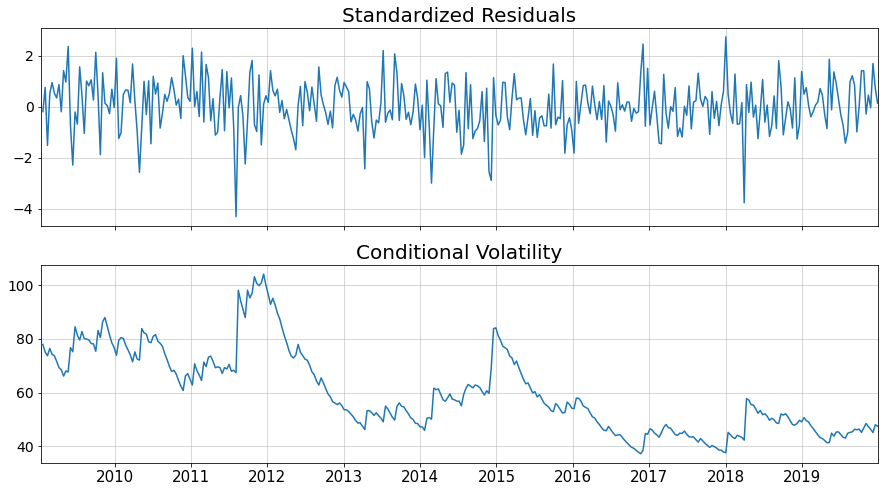

In [50]:
argarch_by_week_series_fitted.plot();

In [51]:
q = argarch_by_week_series_fitted.forecast(horizon=3, method='simulation', simulations=1_000).simulations.values

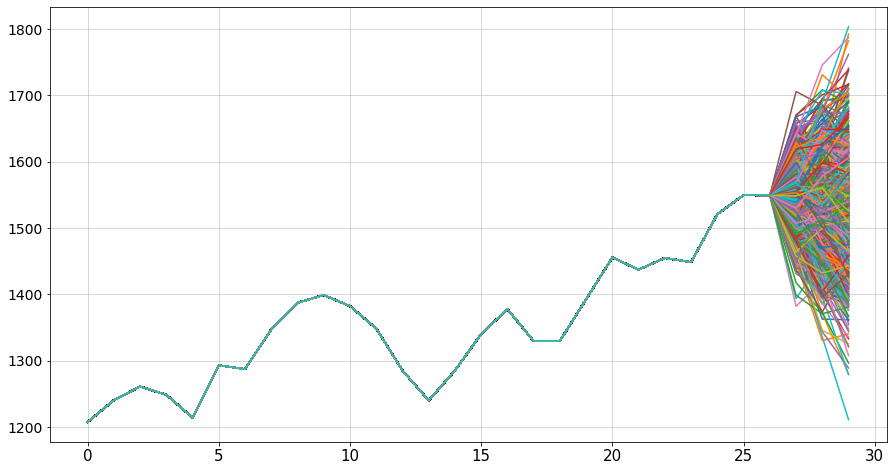

In [52]:
_ = []
for i in q[-1]:
    _.extend(i)
    plt.plot(
        range(len(week_series) + len(i))[:30],
        np.append(week_series.to_list(), _)[-30:]
    )
    _.clear()

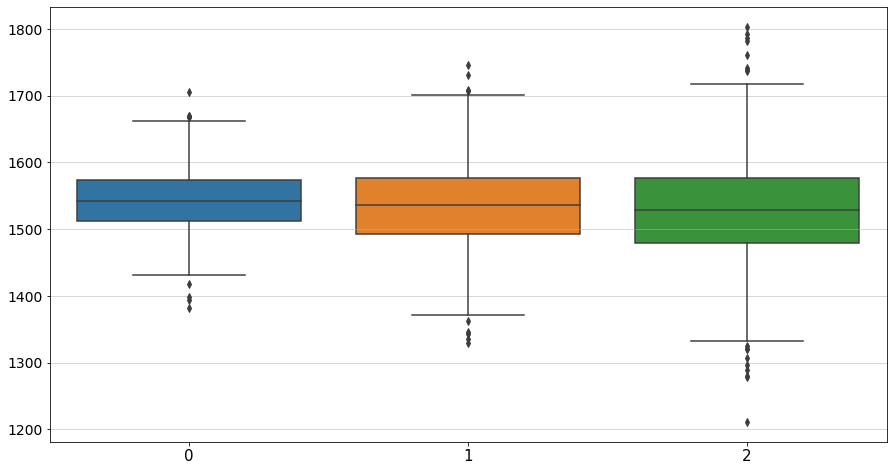

In [53]:
sns.boxplot(data=q[-1]);

# VAR модель

[-2.66359249 -1.70970751]


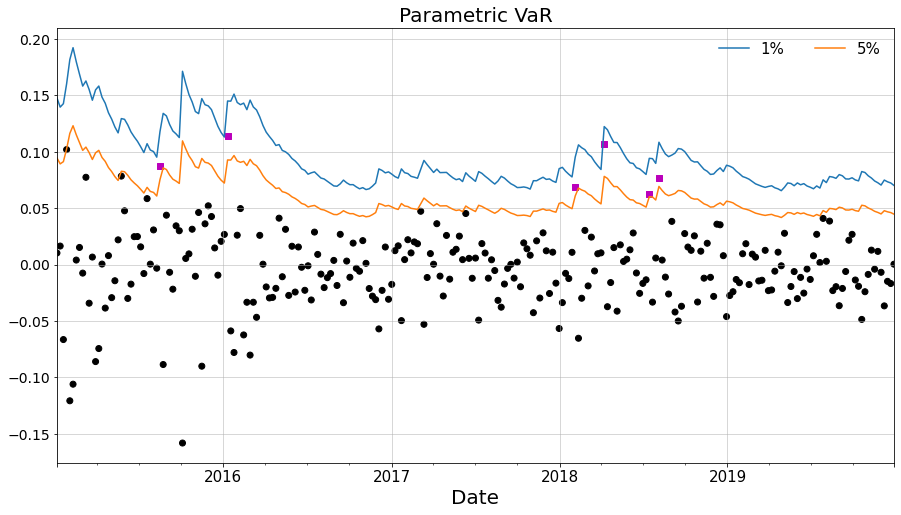

In [54]:
# week_series_changed = arch.data.sp500.load()['Adj Close'].pct_change().dropna() * 100
week_series_changed = df[('2009-01' < df.index) & (df.index < '2020')].Close
week_series_changed = week_series_changed.resample('7d').last()

week_series_changed = week_series_changed.pct_change().dropna()
am = arch_model(week_series_changed, vol='Garch', p=1, o=0, q=1, dist='skewt')
res = am.fit(disp='off', last_obs='2014-12-31')

forecasts = res.forecast(start='2015-1-1')
cond_mean = forecasts.mean['2015':]
cond_var = forecasts.variance['2015':]
q = am.distribution.ppf([0.01, 0.05], res.params[-2:])
print(q)

value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(
    value_at_risk, columns=['1%', '5%'], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = week_series_changed['2015':].copy()
rets_2018.name = 'S&P 500 Return'
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2018[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
c = np.array(c, dtype='object')
labels = {
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}
markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
    )
ax.set_title('Parametric VaR')
leg = ax.legend(frameon=False, ncol=3)

# Holt-Winters